In [1]:
# Import libraries 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
import matplotlib.pyplot as plt

#### 0. To do:

- Investigate probabilities of predicted labels.
- Convert logistic regression into pytorch.
- Explore how learning rate affects data fitting.
- Use a more complicated example, e.g., protein related?
- Implement a simple neural network using PyTorch for classfication.
- Implement boundary decision plotting.

#### I. Generate training data.

Understanding the data input:
- `X` denotes the training dataset, where each column represents number of examples (`m`), whilst each row represents features (`n_x`). `X` has a shape of `(n_x, m)`. For instance, `X` has 100 examples with 2 features each.
- `Y` represents the output with a shape `(1, m)`.

In [2]:
# Generate sample data for logistic regression
# X
np.random.seed(0)
cloud_1 = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0],[0, 1]], size=100)
cloud_2 = np.random.multivariate_normal(mean=[4, 0], cov=[[1, 0],[0, 1]], size=100)
X = np.vstack((cloud_1, cloud_2)).T
# Y
cloud_1_y = np.zeros((1, cloud_1.shape[0]))
cloud_2_y = np.ones((1, cloud_2.shape[0]))
Y = np.hstack((cloud_1_y, cloud_2_y))

In [3]:
# Split sample data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.2, random_state=0)
X_train = X_train.T
X_test = X_test.T
Y_train = Y_train.T
Y_test = Y_test.T

In [4]:
# Plot as a scatter plot
plt.scatter(X_train[0, :], X_train[1, :], c=y_train, cmap="coolwarm", label="train")
plt.scatter(X_test[0, :], X_test[1, :], edgecolors="k", c=y_test, cmap="coolwarm", label="test")
plt.legend()

NameError: name 'y_train' is not defined

#### II. Implement a logistic regression model using `numpy` and compare it with `scikit-learn` implementation.

#### Mathematical expression of the algorithm:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

#### Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Compute parameter gradients with respect to the cost: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

#### Optimize:
The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

#### Predict:
Use previosuly learnt parameters `W` and `b` to predict labels for test data. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`.

In [5]:
def sigmoid(x):
    """ Transform a given value(s) using a sigmoid function."""
    return 1 / (1 + np.exp(-x))

def initialize_weights(dim):
    """ 
    Initialize weights and biases for logistic regression model.
    
    Parameters
    ----------
    dim : int
        Size of a weights np.ndarray of shape (dim, 1)
    
    Returns
    -------
    W, b : nd.array, float
        Zero matrix of shape (dim, 1) and float value of 0.0
        corresponding to weights and bias term, respectively.
    """
    
    W = np.zeros((dim, 1))
    b = 0.0
    
    return W, b

def forward_propagation(X, Y, W, b):
    """ 
    Perform a forward propagation and compute the gradient.

    Parameters
    ----------
    X : nd.array
        Examples matrix of a shape(n_x, m).
    Y : nd.array
        Labels matrix of a shape(1, m).
    W : nd.array
        Weights matrix of a shape(dim, 1).
    b : float
        Bias term.

    Returns
    -------
    cost : float
        Cost value of a single propagation pass.
    dW : float
        Weights gradient with respect to the cost.
    db : float
        Bias gradient with respect to the cost.
    """

    # Get the number of training examples
    m = X.shape[0]

    # Compute the forward propagation
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)

    # Compute the cost over all training examples
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    # Compute the gradients
    dW = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)
    
    return cost, dW, db

def optimize(X, Y, W, b, num_iterations=100, learning_rate=0.001):
    """ 
    Perform optimization of a logistic regression model.

    Parameters
    ----------
    X : nd.array
        Examples matrix of a shape(n_x, m).
    Y : nd.array
        Labels matrix of a shape(1, m).
    W : nd.array
        Weights matrix of a shape(dim, 1).
    b : float
        Bias term.
    num_iterations : int
        Number of iterations to optimize the model.
    learning_rate : float
        Learning rate for the parameter update rule.

    Returns
    -------
    params : dict
        Dictionary of values containing optimized parameters, "W" and "b".
    grads : dict
        Dictionary of values containing gradients, "dW" and "db".
    """

    # Update parameters, compute gradients, and collect cost
    costs = []
    for i in range(num_iterations):
        cost, dW, db = forward_propagation(X, Y, W, b)
        W = W - learning_rate * dW
        b = b - learning_rate * db
        costs.append(cost)

    # Collect parameters and gradients
    params = {"W": W, "b": b}
    grads = {"dW": dW, "db": db}
    
    return params, grads, costs

def predict(X, W, b):
    """ 
    Predict labels.

    Parameters
    ----------
    X : nd.array
        Examples matrix of a shape(n_x, m).
    W : nd.array
        Weights matrix of a shape(dim, 1).
    b : float
        Bias term.

    Returns
    -------
    Y_prediction : nd.array
        Predicted labels (0, or 1) matrix of a shape(1, m).
    """

    # Use previously learnt parameters
    Z = np.dot(W.T, X) + b
    A = sigmoid(Z)

    # Convert predictions probabilities to either 0 or 1
    A[A <= 0.5] = 0
    A[A > 0.5] = 1
    Y_prediction = A
    
    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations=100, learning_rate=0.001):
    """ 
    Train a model and get back the costs and Y predictions for training and test sets.

    Parameters
    ----------
    X_train : nd.array
        Training examples matrix with a shape(n_x, m).
    Y_train : nd.array
        Training labels matrix with a shape(1, m).
    X_test : nd.array
        Test examples matrix with a shape(n_x, m).
    Y_test : nd.array
        Test labels matrix with a shape(1, m).
    num_iterations : int
        Number of iterations to optimize the model.
    learning_rate : float
        Learning rate for the parameter update rule.
    
    Parameters
    ----------
    costs : list
        A list of costs for each iteration.
    Y_prediction_train : nd.array
        Predicted training labels (0, or 1) matrix of a shape(1, m).
    Y_prediction_test : nd.array
        Predicted test labels (0, or 1) matrix of a shape(1, m).
    """
    
    # Initialize weights
    W, b = initialize_weights(dim=X_train.shape[0])
    
    # Optimize parameters and compute the cost
    params, grads, costs = optimize(X=X_train, Y=Y_train, W=W, b=b, num_iterations=num_iterations, learning_rate=learning_rate)

    # Make a prediction about training and test sets
    W_opt = params["W"]
    b_opt = params["b"]
    Y_prediction_train = predict(X=X_train, W=W_opt, b=b_opt)
    Y_prediction_test = predict(X=X_test, W=W_opt, b=b_opt)
    
    return costs, Y_prediction_train, Y_prediction_test

In [6]:
# Run the model
costs, Y_prediction_train, Y_prediction_test = model(
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_iterations=1000,
    learning_rate=0.001
)
# Compute the accuracy for training and test sets
train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 96.25
Test accuracy: 97.5


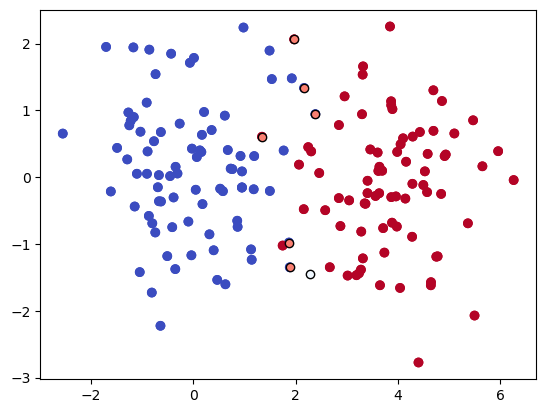

In [7]:
# Plot values that have been mislabeled
mask_train = np.abs(Y_prediction_train - Y_train) == 1
mask_test = np.abs(Y_prediction_test - Y_test) == 1

X_train_masked = X_train[:, mask_train[0]]
X_test_masked = X_test[:, mask_test[0]]

plt.scatter(X_train[0, :], X_train[1, :], c=Y_train, cmap="coolwarm")
plt.scatter(X_train[0, :], X_train[1, :], c=Y_train, cmap="coolwarm")
plt.scatter(X_train_masked[0, :], X_train_masked[1, :], color="salmon", edgecolor="k")
plt.scatter(X_test_masked[0, :], X_test_masked[1, :], color="aliceblue", edgecolor="k")

Text(0, 0.5, 'Cost')

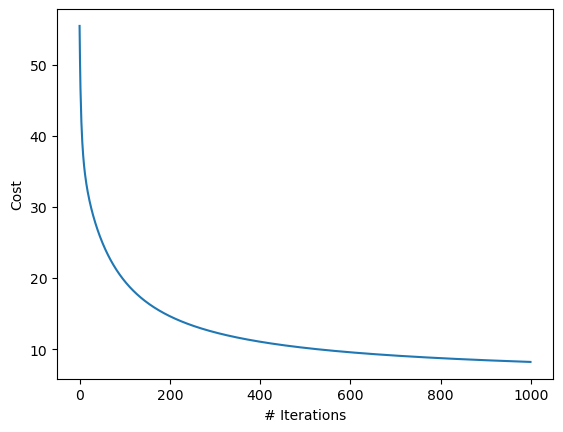

In [18]:
plt.plot(costs)
plt.xlabel("# Iterations")
plt.ylabel("Cost")

In [19]:
# Run a logistic regression using scikit-learn
# Fit the model
clf = LogisticRegression(
    penalty=None, 
    random_state=0
)
clf.fit(X_train.T, Y_train.T)
# Predict labe;s
Y_prediction_train_sklearn = clf.predict(X_train.T)
Y_prediction_test_sklearn = clf.predict(X_test.T)
# Compute model accuracy for training and test training sets
train_accuracy = 100 - np.mean(np.abs(Y_prediction_train_sklearn - Y_train)) * 100
test_accuracy = 100 - np.mean(np.abs(Y_prediction_test_sklearn - Y_test)) * 100
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 96.25
Test accuracy: 97.5


/home/kausasm/miniconda3/envs/aiml/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


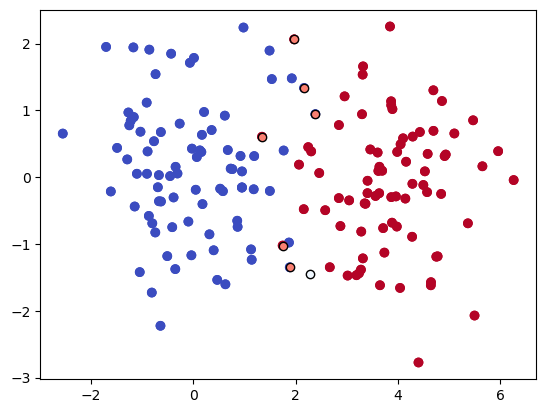

In [172]:
# Plot values that have been mislabeled
mask_train = np.abs(Y_prediction_train_sklearn - Y_train) == 1
mask_test = np.abs(Y_prediction_test_sklearn - Y_test) == 1

X_train_masked = X_train[:, mask_train[0]]
X_test_masked = X_test[:, mask_test[0]]

plt.scatter(X_train[0, :], X_train[1, :], c=y_train, cmap="coolwarm")
plt.scatter(X_train[0, :], X_train[1, :], c=y_train, cmap="coolwarm")
plt.scatter(X_train_masked[0, :], X_train_masked[1, :], color="salmon", edgecolor="k")
plt.scatter(X_test_masked[0, :], X_test_masked[1, :], color="aliceblue", edgecolor="k")

#### II. Implement a logistic regression using `pytorch` 

In [100]:
def sigmoid_torch(x):
    """ Transform a given value(s) using a sigmoid function."""
    return torch.sigmoid(x)

def initialize_weights_torch(dim):
    """ 
    Initialize weights and biases for logistic regression model.
    
    Parameters
    ----------
    dim : int
        Size of a weights np.ndarray of shape (dim, 1)
    
    Returns
    -------
    W, b : torch.Tensor, float
        Zero matrix of shape (dim, 1) and float value of 0.0
        corresponding to weights and bias term, respectively.
    """
    
    W = torch.zeros((dim, 1))
    b = 0.0
    
    return W, b

def forward_propagation_torch(X, Y, W, b):
    """ 
    Perform a forward propagation and compute the gradient.

    Parameters
    ----------
    X : torch.Tensor
        Examples matrix of a shape(n_x, m).
    Y : torch.Tensor
        Labels matrix of a shape(1, m).
    W : torch.Tensor
        Weights matrix of a shape(dim, 1).
    b : float
        Bias term.

    Returns
    -------
    cost : float
        Cost value of a single propagation pass.
    dW : float
        Weights gradient with respect to the cost.
    db : float
        Bias gradient with respect to the cost.
    """

    # Get the number of training examples
    m = X.shape[0]

    # Compute the forward propagation
    Z = torch.tensordot(W.T, X, dims=1) + b
    A = sigmoid_torch(Z)

    # Compute the cost over all training examples
    cost = -1 / m * torch.sum(Y * torch.log(A) + (1 - Y) * torch.log(1 - A))
    
    # Compute the gradients
    dW = 1 / m * torch.tensordot(X, (A - Y).T, dims=1)
    db = 1 / m * torch.sum(A - Y)
    
    return cost, dW, db

def optimize_torch(X, Y, W, b, num_iterations=100, learning_rate=0.001):
    """ 
    Perform optimization of a logistic regression model.

    Parameters
    ----------
    X : torch.tensor
        Examples matrix of a shape(n_x, m).
    Y : torch.tensor
        Labels matrix of a shape(1, m).
    W : torch.tensor
        Weights matrix of a shape(dim, 1).
    b : float
        Bias term.
    num_iterations : int
        Number of iterations to optimize the model.
    learning_rate : float
        Learning rate for the parameter update rule.

    Returns
    -------
    params : dict
        Dictionary of values containing optimized parameters, "W" and "b".
    grads : dict
        Dictionary of values containing gradients, "dW" and "db".
    """

    # Update parameters, compute gradients, and collect cost
    costs = []
    for i in range(num_iterations):
        cost, dW, db = forward_propagation_torch(X, Y, W, b)
        W = W - learning_rate * dW
        b = b - learning_rate * db
        costs.append(cost)

    # Collect parameters and gradients
    params = {"W": W, "b": b}
    grads = {"dW": dW, "db": db}
    
    return params, grads, costs

def predict_torch(X, W, b):
    """ 
    Predict labels.

    Parameters
    ----------
    X : torch.tensor
        Examples matrix of a shape(n_x, m).
    W : torch.tensor
        Weights matrix of a shape(dim, 1).
    b : float
        Bias term.

    Returns
    -------
    Y_prediction : nd.array
        Predicted labels (0, or 1) matrix of a shape(1, m).
    """

    # Use previously learnt parameters
    Z = torch.tensordot(W.T, X, dims=1) + b
    A = sigmoid_torch(Z)

    # Convert predictions probabilities to either 0 or 1
    A[A <= 0.5] = 0
    A[A > 0.5] = 1
    Y_prediction = A
    
    return Y_prediction

def model_torch(X_train, Y_train, X_test, Y_test, num_iterations=100, learning_rate=0.001):
    """ 
    Train a model and get back the costs and Y predictions for training and test sets.

    Parameters
    ----------
    X_train : torch.tensor
        Training examples matrix with a shape(n_x, m).
    Y_train : torch.tensor
        Training labels matrix with a shape(1, m).
    X_test : torch.tensor
        Test examples matrix with a shape(n_x, m).
    Y_test : torch.tensor
        Test labels matrix with a shape(1, m).
    num_iterations : int
        Number of iterations to optimize the model.
    learning_rate : float
        Learning rate for the parameter update rule.
    
    Parameters
    ----------
    costs : list
        A list of costs for each iteration.
    Y_prediction_train : torch.tensor
        Predicted training labels (0, or 1) matrix of a shape(1, m).
    Y_prediction_test : torch.tensor
        Predicted test labels (0, or 1) matrix of a shape(1, m).
    """
    
    # Initialize weights
    W, b = initialize_weights_torch(dim=X_train.shape[0])
    
    # Optimize parameters and compute the cost
    params, grads, costs = optimize_torch(X=X_train, Y=Y_train, W=W, b=b, num_iterations=num_iterations, learning_rate=learning_rate)

    # Make a prediction about training and test sets
    W_opt = params["W"]
    b_opt = params["b"]
    Y_prediction_train = predict_torch(X=X_train, W=W_opt, b=b_opt)
    Y_prediction_test = predict_torch(X=X_test, W=W_opt, b=b_opt)
    
    return costs, Y_prediction_train, Y_prediction_test

In [101]:
# Convert training and test sets to torch.tensor
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
Y_train_tensor = torch.from_numpy(Y_train).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

In [104]:
# Run the model
costs, Y_prediction_train, Y_prediction_test = model_torch(
    X_train=X_train_tensor,
    Y_train=Y_train_tensor,
    X_test=X_test_tensor,
    Y_test=Y_test_tensor,
    num_iterations=1000,
    learning_rate=0.001
)
# Compute the accuracy for training and test sets
train_accuracy = 100 - torch.mean(torch.abs(Y_prediction_train - Y_train)) * 100
test_accuracy = 100 - torch.mean(torch.abs(Y_prediction_test - Y_test)) * 100
print("Train accuracy: {}".format(train_accuracy))
print("Test accuracy: {}".format(test_accuracy))

Train accuracy: 96.25
Test accuracy: 97.5
